# PyTorch Inference Optimizations with Intel® Advanced Matrix Extensions (Intel® AMX)  Bfloat16 Integer8

This code sample will perform inference on the ResNet50 and BERT models while using Intel® Extension for PyTorch (IPEX). For each pretrained model, there will be a warm up of 20 samples before running inference on the specified number of samples (i.e. 1000) to record the time. Intel® Advanced Matrix Extensions (Intel® AMX) is supported on BF16 and INT8 data types starting with the 4th Generation of Xeon Scalable Processors. The inference time will be compared, showcasing the speedup over FP32 when using AVX-512, Intel® AMX, BF16, and INT8. The following run cases are executed:  

1. FP32 (baseline)
2. BF16 using AVX512_CORE_AMX
3. INT8 using AVX512_CORE_VNNI
4. INT8 using AVX512_CORE_AMX

## Environment Setup

Ensure the PyTorch kernel is activated before running this notebook.

## Imports, Constants

In [2]:
import os
from time import time
import matplotlib.pyplot as plt
import torch
import intel_extension_for_pytorch as ipex
from intel_extension_for_pytorch.quantization import prepare, convert
import torchvision
from torchvision import models
from transformers import BertModel

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SUPPORTED_MODELS = ["resnet50", "bert"]   # models supported by this code sample

# ResNet sample data parameters
RESNET_BATCH_SIZE = 64

# BERT sample data parameters
BERT_BATCH_SIZE = 64
BERT_SEQ_LENGTH = 512

## Identify Supported ISA  
We identify the underlying supported ISA to determine whether Intel® AMX is supported. The 4th Gen Intel® Xeon® Scalable Processor (codenamed Sapphire Rapids) or newer must be used to run this sample.  

In [5]:
# Check if hardware supports Intel® AMX
import sys
sys.path.append('../../')
import version_check
from cpuinfo import get_cpu_info
info = get_cpu_info()
flags = info['flags']
amx_supported = False
for flag in flags:
    if "amx" in flag:
        amx_supported = True
        break
if not amx_supported:
    print("Intel® AMX is not supported on current hardware. Code sample cannot be run.\n")

If the message "Intel® AMX is not supported on current hardware. Code sample cannot be run." is printed above, the hardware being used does not support Intel® AMX. Therefore, this code sample cannot proceed.

## Running Inference
The function runInference() will perform inference on the selected model, precision, and whether Intel® AMX is to be enabled. The environment variable `ONEDNN_MAX_CPU_ISA` is used to enable or disable Intel® AMX. **Note that this environment variable is only initialized once.** This means to run with Intel® AMX and Intel® VNNI, there will need to be separate processes. The best practice is to set this environment variable before running your script. For more information, refer to the [oneDNN documentation on CPU Dispatcher Control](https://www.intel.com/content/www/us/en/develop/documentation/onednn-developer-guide-and-reference/top/performance-profiling-and-inspection/cpu-dispatcher-control.html). 

To use BF16 in operations, use the `torch.cpu.amp.autocast()` function to perform forward pass. For INT8, the quantization feature from Intel® Extension for PyTorch (IPEX) is used to quantize the FP32 model to INT8 before running inference.

Torchscript is also utilized to deploy the model in graph mode instead of imperative mode for faster runtime.

In [7]:
os.environ["ONEDNN_MAX_CPU_ISA"] = "AVX512_CORE_AMX"

In [8]:
"""
Function to perform inference on Resnet50 and BERT
"""
def runInference(model, data, modelName="resnet50", dataType="FP32", amx=True):
    """
    Input parameters
        model: the PyTorch model object used for inference
        data: a sample input into the model
        modelName: str representing the name of the model, supported values - resnet50, bert
        dataType: str representing the data type for model parameters, supported values - FP32, BF16, INT8
        amx: set to False to disable Intel® AMX  on BF16, Default: True
    Return value
        inference_time: the time in seconds it takes to perform inference with the model
    """
    
    # Display run case
    if amx:
        isa_text = "AVX512_CORE_AMX"
    else:
        isa_text = "AVX512_CORE_VNNI"
    print("%s %s inference with %s" %(modelName, dataType, isa_text))

    # Special variables for specific models
    batch_size = None
    if "resnet50" == modelName:
        batch_size = RESNET_BATCH_SIZE
    elif "bert" == modelName:
        d = torch.randint(model.config.vocab_size, size=[BERT_BATCH_SIZE, BERT_SEQ_LENGTH]) # sample data input for torchscript and inference
        batch_size = BERT_BATCH_SIZE
    else:
        raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))

    # Prepare model for inference based on precision (FP32, BF16, INT8)
    if "INT8" == dataType:
        # Quantize model to INT8 if needed (one time)
        model_filename = "quantized_model_%s.pt" %modelName
        if not os.path.exists(model_filename):
            qconfig = ipex.quantization.default_static_qconfig
            prepared_model = prepare(model, qconfig, example_inputs=data, inplace=False)
            converted_model = convert(prepared_model)
            with torch.no_grad():
                if "resnet50" == modelName:
                    traced_model = torch.jit.trace(converted_model, data)
                elif "bert" == modelName:
                    traced_model = torch.jit.trace(converted_model, (d,), check_trace=False, strict=False)
                else:
                    raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
                traced_model = torch.jit.freeze(traced_model)
            traced_model.save(model_filename)

        # Load INT8 model for inference
        model = torch.jit.load(model_filename)
        model.eval()
        model = torch.jit.freeze(model)
    elif "BF16" == dataType:
        model = ipex.optimize(model, dtype=torch.bfloat16)
        with torch.no_grad():
            with torch.cpu.amp.autocast():
                if "resnet50" == modelName:
                    model = torch.jit.trace(model, data)
                elif "bert" == modelName:
                    model = torch.jit.trace(model, (d,), check_trace=False, strict=False)
                else:
                    raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
                model = torch.jit.freeze(model)
    else: # FP32
        with torch.no_grad():
            if "resnet50" == modelName:
                model = torch.jit.trace(model, data)
            elif "bert" == modelName:
                model = torch.jit.trace(model, (d,), check_trace=False, strict=False)
            else:
                raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
            model = torch.jit.freeze(model)

    # Run inference
    with torch.no_grad():
        if "BF16" == dataType:
            with torch.cpu.amp.autocast():
                # Warm up
                for i in range(5):
                    model(data)
                
                # Measure latency
                start_time = time()
                model(data)
                end_time = time()
        else:
            # Warm up
            for i in range(5):
                model(data)
            
            # Measure latency
            start_time = time()
            model(data)
            end_time = time()
    inference_time = end_time - start_time
    print("Inference on batch size %d took %.3f seconds" %(batch_size, inference_time))

    return inference_time

The function summarizeResults() displays the inference times and generates one graph for comparing the inference times and another graph for comparing the speedup using FP32 as the baseline.

In [22]:
"""
Prints out results and displays figures summarizing output.
"""
def summarizeResults(modelName="", results=None, batch_size=1):
    """
    Input parameters
        modelName: a str representing the name of the model
        results: a dict with the run case and its corresponding time in seconds
        batch_size: an integer for the batch size
    Return value
        None
    """

    # Inference time results
    print("\nSummary for %s (Batch Size = %d)" %(modelName, batch_size))
    for key in results.keys():
        try:
            print("%s inference time: %.3f seconds" %(key, results[key]))
        except:
            results[key]=1
            print(f"No results for {key}")

    # Create bar chart with inference time results
    plt.figure()
    plt.title("%s Inference Time (Batch Size = %d)" %(modelName, batch_size))
    plt.xlabel("Run Case")
    plt.ylabel("Inference Time (seconds)")
    plt.bar(results.keys(), results.values())

    # Calculate speedup when using Intel® AMX
    print("\n")
    bf16_with_amx_speedup = results["FP32"] / results["BF16_with_AMX"]
    print("BF16 with Intel® AMX  is %.2fX faster than FP32" %bf16_with_amx_speedup)
    int8_with_vnni_speedup = results["FP32"] / results["INT8_with_VNNI"]
    print("INT8 without Intel® AMX  is %.2fX faster than FP32" %int8_with_vnni_speedup)
    int8_with_amx_speedup = results["FP32"] / results["INT8_with_AMX"]
    print("INT8 with Intel® AMX  is %.2fX faster than FP32" %int8_with_amx_speedup)
    print("\n\n")

    # Create bar chart with speedup results
    plt.figure()
    plt.title("%s Intel® AMX  BF16/INT8 Speedup over FP32" %modelName)
    plt.xlabel("Run Case")
    plt.ylabel("Speedup")
    plt.bar(results.keys(), 
        [1, bf16_with_amx_speedup, int8_with_vnni_speedup, int8_with_amx_speedup]
    )

### VNNI: ResNet50 and BERT
Since ONEDNN_MAX_CPU_ISA is initialized ONCE when a workload is being run, another process must be used to run with a different setting. 
In other words, changing ONEDNN_MAX_CPU_ISA during runtime in the same process will not have any effect.
Thus, to run with VNNI, a separate script is run.

In [10]:
!python pytorch_inference_vnni.py

/bin/bash: line 1: python: command not found


In [11]:
# Record the inference times for INT8 using AVX-512
int8_with_vnni_resnet_inference_time = None   #TODO: enter in inference time
int8_with_vnni_bert_inference_time = None     #TODO: enter in inference time

### : ResNet50

In [12]:
# Set up ResNet50 model and sample data
resnet_model = models.resnet50(pretrained=True)
resnet_data = torch.rand(RESNET_BATCH_SIZE, 3, 224, 224)
resnet_model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# FP32 (baseline)
fp32_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="FP32", amx=True)

resnet50 FP32 inference with AVX512_CORE_AMX
Inference on batch size 64 took 1.518 seconds


In [14]:
# BF16 using Intel® 
bf16_amx_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="BF16", amx=True)

resnet50 BF16 inference with AVX512_CORE_AMX
Inference on batch size 64 took 0.144 seconds


In [15]:
# INT8 using Intel® 
int8_amx_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="INT8", amx=True)

resnet50 INT8 inference with AVX512_CORE_AMX
Inference on batch size 64 took 0.073 seconds



Summary for ResNet50 (Batch Size = 64)
FP32 inference time: 1.518 seconds
BF16_with_AMX inference time: 0.144 seconds
No results for INT8_with_VNNI
INT8_with_AMX inference time: 0.073 seconds


BF16 with Intel® AMX  is 10.56X faster than FP32
INT8 without Intel® AMX  is 1.52X faster than FP32
INT8 with Intel® AMX  is 20.67X faster than FP32





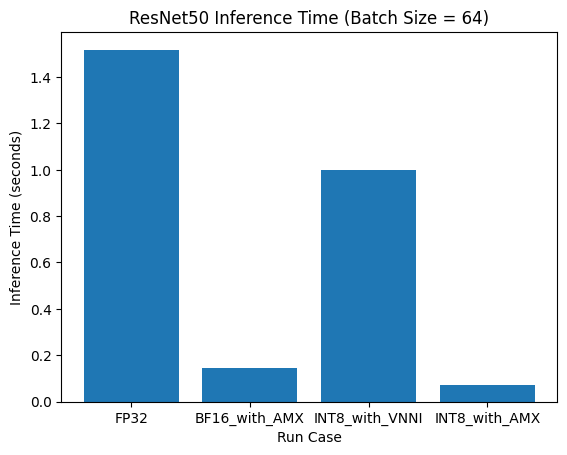

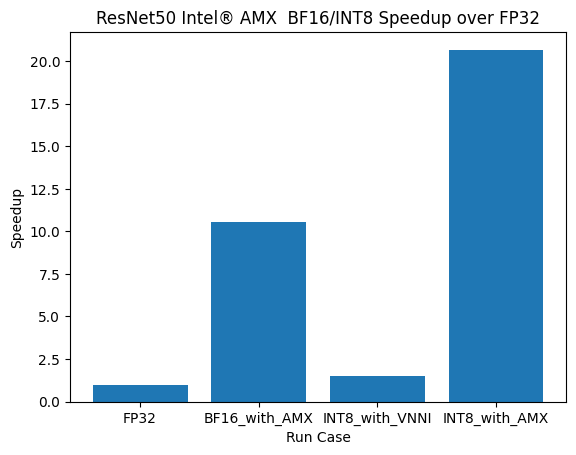

In [23]:
# Summarize and display results
results_resnet = {
        "FP32": fp32_resnet_inference_time,
        "BF16_with_AMX": bf16_amx_resnet_inference_time,
        "INT8_with_VNNI": int8_with_vnni_resnet_inference_time,
        "INT8_with_AMX": int8_amx_resnet_inference_time
    }
summarizeResults("ResNet50", results_resnet, RESNET_BATCH_SIZE)
plt.show()

In [27]:
os.environ["HF_ENDPOINT"]="https://hf-mirror.com" #in china, do it in python rather than ipython to download the models from huggingface.

The first graph displays the inference times on the specified number of samples. In general, the times should be decreasing from left to right because using lower precision and with  accelerates the computations. The second graph displays the relative speedup of each run case compared to that of FP32. In general the speedup should be increasing from left to right.

###  BERT

In [29]:
# Set up BERT model and sample data
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased') 
bert_data = torch.randint(bert_model.config.vocab_size, size=[BERT_BATCH_SIZE, BERT_SEQ_LENGTH])
bert_model.eval()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [30]:
# FP32 (baseline)
fp32_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="FP32", amx=True)

bert FP32 inference with AVX512_CORE_AMX
Inference on batch size 64 took 13.857 seconds


In [31]:
# BF16 using Intel® 
bf16_amx_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="BF16", amx=True)

bert BF16 inference with AVX512_CORE_AMX
Inference on batch size 64 took 4.392 seconds


: 

In [ ]:
# INT8 using Intel® 
int8_amx_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="INT8", amx=True)

bert INT8 inference with AVX512_CORE_AMX


In [ ]:
# Summarize and display results
results_bert = {
        "FP32": fp32_bert_inference_time,
        "BF16_with_AMX": bf16_amx_bert_inference_time,
        "INT8_with_VNNI": int8_with_vnni_bert_inference_time,
        "INT8_with_AMX": int8_amx_bert_inference_time
    }
summarizeResults("BERT", results_bert, BERT_BATCH_SIZE)
plt.show()

The first graph displays the inference times on the specified number of samples. In general, the times should be decreasing from left to right because using lower precision and with  accelerates the computations. The second graph displays the relative speedup of each run case compared to that of FP32. In general the speedup should be increasing from left to right.

## Conclusion

This code sample shows how to enable and disable  during runtime, as well as the performance improvements using  BF16 and INT8 for inference on the ResNet50 and BERT models. Performance will vary based on your hardware and software versions. To see a larger performance gap between VNNI and , increase the batch size. For even more speedup, consider using the Intel® Extension for PyTorch (IPEX) [Launch Script](https://intel.github.io/intel-extension-for-pytorch/cpu/latest/tutorials/performance_tuning/launch_script.html). 

In [ ]:
print('[CODE_SAMPLE_COMPLETED_SUCCESSFULLY]')